# **Analyse Combinée de Sentiment et de Données Financières des Actions Boursières**

Ce notebook Jupyter (Colab) est conçu pour offrir une analyse complète des actions boursières, combinant l'analyse de sentiment des commentaires sur Reddit avec la collecte de données financières via Alpha Vantage. Les utilisateurs peuvent choisir n'importe quel symbole boursier pour obtenir une vue d'ensemble de la perception publique ainsi que des performances financières récentes de l'entreprise.

# **Objectif**

Ce notebook vise à fournir aux investisseurs, aux analystes financiers et aux amateurs de données une plateforme intégrée pour analyser à la fois les sentiments publics et les données financières d'une entreprise. Cela permet une prise de décision plus informée en incorporant des analyses qualitatives et quantitatives.

# **Prérequis**

Pour utiliser ce notebook, vous aurez besoin d'accès à des clés API valides pour Reddit et Alpha Vantage. Une familiarité avec Python, l'analyse de données, et les concepts financiers de base est recommandée pour maximiser les bénéfices de cet outil analytique.


***Ces commandes installeront les bibliothèques asyncpraw pour l'interaction asynchrone avec l'API Reddit, pandas pour la manipulation et l'analyse des données, et praw pour l'interaction avec l'API Reddit de manière synchrone. Ces bibliothèques sont essentielles pour le traitement et l'analyse des données comme décrit dans les objectifs de votre notebook Colab.***

In [12]:
pip install asyncpraw


In [1]:
pip install pandas


In [14]:
pip install praw

"""
Ce script Python utilise asyncpraw (une version asynchrone de PRAW, l'API Python Reddit) pour collecter et analyser les commentaires de plusieurs subreddits spécifiques relatifs a un symbole boursier. Il vise à identifier les sentiments généraux (positifs, négatifs, neutres) exprimés dans ces commentaires sur une période de l'année passée, en utilisant l'analyseur de sentiments VADER de la bibliothèque NLTK.

Fonctionnalités principales :
1. Collecte des commentaires récents contenant un mot-clé "" dans les subreddits liés à la finance et à l'investissement.
2. Analyse des sentiments de ces commentaires pour déterminer leur polarité (positif, négatif, neutre).
3. Aggrégation des résultats par jour et détermination du sentiment dominant pour chaque jour.
4. Sauvegarde des scores de sentiment quotidiens dans un fichier CSV pour une analyse ultérieure.

Ce script démontre l'utilisation de l'asynchronie pour améliorer l'efficacité de la collecte de données sur Reddit, ainsi que l'application de l'analyse de sentiments NLP pour extraire des insights à partir de données textuelles brutes.

Prérequis :
- Python 3.6+
- Bibliothèques : asyncio, asyncpraw, asyncprawcore, pandas, nltk (avec vader_lexicon téléchargé)

Usage :
Ce script est destiné à être exécuté comme un script autonome. Assurez-vous d'avoir configuré les identifiants de l'API Reddit (client_id, client_secret) avant l'exécution.
"""


In [ ]:
import asyncio
import asyncpraw
from collections import Counter
import datetime
import asyncprawcore
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Téléchargement du lexique VADER pour l'analyse des sentiments
nltk.download('vader_lexicon')

# Définition d'une fonction pour classer les scores de sentiment
def classify_sentiment(score):
    """Classifie le score de sentiment en positif, négatif ou neutre."""
    if score > 0.05:  # Seuil pour positif
        return 1
    elif score < -0.05:  # Seuil pour négatif
        return -1
    else:
        return 0  # Neutre

async def collect_comments(reddit, subreddit_name, date_limite, sid, keyword):
    """Collecte les commentaires d'un subreddit spécifique contenant un mot-clé et analyse leur sentiment."""
    subreddit = await reddit.subreddit(subreddit_name)
    comments_data = []

    # Parcourir les soumissions récentes
    async for submission in subreddit.new(limit=None):  # Enlever la limite ou la mettre très haute
        submission_date = datetime.datetime.utcfromtimestamp(submission.created_utc).date()
        if submission_date >= date_limite:
            try:
                await submission.load()
                if submission.comments:
                    await submission.comments.replace_more(limit=0)
                    for comment in submission.comments.list():
                        if comment and comment.body and keyword.lower() in comment.body.lower():
                            sentiment_score = sid.polarity_scores(comment.body)['compound']
                            comments_data.append({
                                'Date': submission_date,
                                'Comment': comment.body,
                                'Sentiment': sentiment_score
                            })
                            # Ajouter un délai pour respecter la limite de requêtes
                            await asyncio.sleep(1)
            except asyncprawcore.exceptions.TooManyRequests as e:
                wait_time = e.response.headers.get("Retry-After", 60)  # Utiliser 60 secondes par défaut si l'header n'est pas présent
                print(f"Rate limit exceeded. Waiting for {wait_time} seconds.")
                await asyncio.sleep(int(wait_time))
            except Exception as e:
                print(f"Error processing comments: {e}")

    return comments_data

async def main():
    """Point d'entrée principal pour la collecte et l'analyse des sentiments des commentaires Reddit."""
    # Configuration de l'instance Reddit avec asyncpraw
    reddit = asyncpraw.Reddit(
        client_id="A5JdkIx6Fd_92LzdvaRhLg",
        client_secret="mHYkASS6LWg0EObYuy745JXQmU6s0w",
        user_agent="APITUTO"
    )

    date_limite = datetime.datetime.utcnow().date() - datetime.timedelta(days=365)  # Collecter des données de l'année passée
    sid = SentimentIntensityAnalyzer()  # Initialisation de l'analyseur de sentiments VADER
    subreddits = ["stocks", "finance", "investing", "wallstreetbets", "StockMarket"]
    keyword = ""  # Symbole boursier à rechercher

    all_comments = []
    for subreddit_name in subreddits:
        comments = await collect_comments(reddit, subreddit_name, date_limite, sid, keyword)
        all_comments.extend(comments)

    # Création d'un DataFrame à partir de all_comments
    df_comments = pd.DataFrame(all_comments)
    # Appliquer la fonction de classification à chaque score de sentiment
    df_comments['Sentiment_Class'] = df_comments['Sentiment'].apply(classify_sentiment)

    # Aggrégation des scores de sentiment par jour
    df_comments['Date'] = pd.to_datetime(df_comments['Date'])
    df_daily_dominant = df_comments.groupby('Date')['Sentiment_Class'].agg(lambda group: Counter(group).most_common(1)[0][0]).reset_index(name='Dominant_Sentiment')

    # Sauvegarde des résultats dans un fichier CSV
    df_daily_dominant.to_csv('NVDA_daily_sentiment_scores.csv', index=False)
    print("Daily sentiment scores successfully saved to CSV.")

if __name__ == "__main__":
  await main()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Daily sentiment scores successfully saved to CSV.


Cette commande installe la bibliothèque alpha_vantage, qui vous permet d'accéder aux données financières et aux indicateurs de marché via l'API Alpha Vantage. Alpha Vantage offre des données gratuites sur les actions, les cryptomonnaies, les devises (forex), et plus encore, ce qui est particulièrement utile pour les analyses financières et les projets d'investissement.

In [6]:
pip install alpha_vantage


Ce script effectue les opérations suivantes :

1. **Importation des bibliothèques nécessaires** : `pandas` pour la manipulation des données, `alpha_vantage.timeseries` pour accéder aux données boursières via l'API Alpha Vantage, et `datetime` pour gérer les dates.
2. **Configuration de la clé API** : Remplacez `''` par votre propre clé API obtenue d'Alpha Vantage.
3. **Définition de la période de récupération des données** : Calcul de la date de début pour récupérer les données des 14 derniers mois.
4. **Récupération des données** : Pour chaque symbole dans la liste `symbols`, le script récupère les données boursières quotidiennes, les reformate pour une meilleure lisibilité et les filtre à partir de la date de début calculée.
5. **Préparation des données pour l'analyse** : Réinitialisation de l'index pour transformer les dates en colonne, ce qui facilite les manipulations et analyses ultérieures.
6. **Sauvegarde des données** : Enregistrement du DataFrame contenant toutes les données récupérées dans un fichier CSV.

Avant de lancer ce script, assurez-vous que votre environnement Python dispose des packages nécessaires (`pandas` et `alpha_vantage`) et que vous avez configuré correctement votre clé API Alpha Vantage. Ce script est un excellent point de départ pour l'analyse financière et peut être adapté pour inclure d'autres symboles boursiers ou modifier la période de récupération des données.


In [7]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import datetime

key = ''  # Remplacez par votre clé API

# Liste des symboles boursiers à analyser
symbols = ['']

# Initialisation d'un DataFrame vide pour stocker toutes les données
all_data = pd.DataFrame()

# Calcul de la date de début pour la récupération des données (14 mois avant aujourd'hui)
start_date = (datetime.datetime.now() - datetime.timedelta(days=365 + (365/12)*2)).strftime('%Y-%m-%d')

# Initialisation de l'objet TimeSeries avec la clé API
ts = TimeSeries(key, output_format='pandas')

for symbol in symbols:
    # Récupération des données boursières quotidiennes du symbole
    data, meta = ts.get_daily(symbol, outputsize='full')
    # Renommage des colonnes pour plus de clarté
    data.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'}, inplace=True)

    # Conversion de l'index en datetime et filtrage des données depuis la date de début
    data.index = pd.to_datetime(data.index)
    data = data[data.index >= start_date]

    # Réinitialisez l'index pour avoir la date comme colonne
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)

    # Concaténation des données récupérées avec le DataFrame global
    all_data = pd.concat([all_data, data], axis=0)

all_data.to_csv('donnees_boursieres_.csv', index=False)


"""
Ce script Python est conçu pour fusionner deux ensembles de données distincts : les données financières quotidiennes et les scores de sentiment quotidien basés sur l'analyse de commentaires sur Reddit. L'objectif est d'explorer la corrélation potentielle entre les mouvements du marché boursier et le sentiment public envers l'entreprise, tel qu'il est exprimé à travers les médias sociaux.

Les étapes principales du script sont les suivantes :
1. Chargement des données financières à partir d'un fichier CSV, avec conversion des dates au format datetime pour une manipulation aisée.
2. Chargement des données de sentiment à partir d'un autre fichier CSV, avec une attention similaire aux formats de date.
3. Fusion des deux ensembles de données sur la base des dates, en utilisant une fusion externe pour s'assurer que toutes les dates présentes dans les deux ensembles sont incluses, même si l'une des parties n'a pas de données correspondantes pour certaines dates.
4. Traitement des valeurs manquantes dans les scores de sentiment, en remplaçant les valeurs NaN par 0 pour indiquer un sentiment neutre par défaut.
5. Conversion du type de la colonne de sentiment en entier pour faciliter les analyses ultérieures.
6. Sélection des colonnes pertinentes pour l'analyse et sauvegarde du DataFrame résultant dans un nouveau fichier CSV pour une utilisation ultérieure.

Ce processus permet une analyse intégrée des performances boursières et de la perception publique, offrant des insights potentiels pour les investisseurs, les analystes et les amateurs de données.
"""


In [ ]:
import pandas as pd

# Charger les données financières
df_financial = pd.read_csv('donnees_boursieres_NVDA.csv')
df_financial['date'] = pd.to_datetime(df_financial['date'])
df_financial.rename(columns={'date': 'Date'}, inplace=True)

# Charger les données de sentiment
df_sentiment = pd.read_csv('NVDA_daily_sentiment_scores.csv')
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])

# Fusionner les données financières avec les données de sentiment, en utilisant une fusion externe pour inclure toutes les dates
df_combined = pd.merge(df_financial, df_sentiment, on='Date', how='outer')

# Remplir les valeurs NaN de 'Dominant_Sentiment' avec 0
df_combined['Dominant_Sentiment'] = df_combined['Dominant_Sentiment'].fillna(0)

# Assurer que 'Dominant_Sentiment' est de type entier
df_combined['Dominant_Sentiment'] = df_combined['Dominant_Sentiment'].astype('Int64')

# Sélectionner les colonnes requises, y compris 'Dominant_Sentiment' maintenant en entiers
df_final = df_combined[['Date', 'open', 'high', 'low', 'close', 'volume', 'Dominant_Sentiment']]

# Sauvegarder le DataFrame final dans un nouveau fichier CSV
df_final.to_csv('NVDA_combined_financial_sentiment.csv', index=False)


"""
Ce script asynchrone est conçu pour analyser le sentiment public envers une action souhaitée en collectant et en évaluant les commentaires des utilisateurs sur différents subreddits liés à la finance et à l'investissement. En utilisant la bibliothèque asyncpraw pour interagir avec l'API Reddit de manière asynchrone, le script extrait les commentaires récents qui mentionnent "le symbol". Chaque commentaire est ensuite analysé avec l'analyseur de sentiments VADER de la bibliothèque NLTK pour déterminer s'il exprime un sentiment positif, négatif, ou neutre.

Principales fonctionnalités du script :
1. Collecte asynchrone des commentaires mentionnant "" dans les subreddits spécifiés sur une période d'un an.
2. Analyse des sentiments de chaque commentaire à l'aide de VADER pour classer les sentiments en positif, négatif ou neutre.
3. Agrégation des données pour calculer le nombre total de commentaires, ainsi que le nombre et le pourcentage de commentaires positifs et négatifs par jour.
4. Sauvegarde des résultats dans un fichier CSV pour une analyse ultérieure.

Ce script peut servir d'outil d'analyse pour les investisseurs, les analystes financiers, ou les passionnés de la technologie et de la finance, en fournissant des insights précieux sur le sentiment du marché envers une action, potentiellement utiles pour la prise de décision en matière d'investissement.

Prérequis :
- Python 3.6 ou plus récent.
- Bibliothèques Python : asyncio, asyncpraw, pandas, nltk (avec le lexique VADER téléchargé).

Note : Assurez-vous d'avoir une clé API valide pour Reddit pour utiliser asyncpraw et de respecter les limites de requêtes lors de l'exécution de ce script.
"""


In [9]:
import asyncio
import asyncpraw
from collections import Counter
import datetime
import asyncprawcore
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def classify_sentiment(score):
    if score > 0.1:
        return 1  # Positive sentiment
    elif score < -0.05:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment


async def collect_comments(reddit, subreddit_name, date_limite, sid, keyword):
    subreddit = await reddit.subreddit(subreddit_name)
    comments_data = []

    async for submission in subreddit.new(limit=None):  # Enlever la limite ou la mettre très haute
        submission_date = datetime.datetime.utcfromtimestamp(submission.created_utc).date()
        if submission_date >= date_limite:
            try:
                await submission.load()
                if submission.comments:
                    await submission.comments.replace_more(limit=0)
                    for comment in submission.comments.list():
                        if comment and comment.body and keyword.lower() in comment.body.lower():
                            sentiment_score = sid.polarity_scores(comment.body)['compound']
                            sentiment_class = classify_sentiment(sentiment_score)  # Utiliser la fonction pour classer le sentiment
                            comments_data.append({
                                'Date': submission_date,
                                'Comment': comment.body,
                                'Sentiment': sentiment_score,
                                'Sentiment_Class': sentiment_class  # Ajouter la classification de sentiment
                           })
                            # Ajouter un délai pour respecter la limite de requêtes
                            await asyncio.sleep(1)
            except asyncprawcore.exceptions.TooManyRequests as e:
                wait_time = e.response.headers.get("Retry-After", 60)  # Utiliser 60 secondes par défaut si l'header n'est pas présent
                print(f"Rate limit exceeded. Waiting for {wait_time} seconds.")
                await asyncio.sleep(int(wait_time))
            except Exception as e:
                print(f"Error processing comments: {e}")




    return comments_data

async def main():
    reddit = asyncpraw.Reddit(
        client_id="",
        client_secret="",
        user_agent=""
    )

    date_limite = datetime.datetime.utcnow().date() - datetime.timedelta(days=365)  # 1 an
    sid = SentimentIntensityAnalyzer()
    subreddits = ["stocks", "finance", "investing", "wallstreetbets", "StockMarket"]
    keyword = ""  # Symbole boursier à rechercher

    all_comments = []
    for subreddit_name in subreddits:
        comments = await collect_comments(reddit, subreddit_name, date_limite, sid, keyword)
        all_comments.extend(comments)

    # Création d'un DataFrame à partir de all_comments
    df_comments = pd.DataFrame(all_comments)

    # Convertir 'Date' en datetime et 'Sentiment_Class' selon la classification
    df_comments['Date'] = pd.to_datetime(df_comments['Date'])

    # Calculer le nombre total de commentaires par jour
    daily_counts = df_comments.groupby('Date')['Sentiment_Class'].count().reset_index(name='Total_Comments')

    # Calculer le nombre de commentaires positifs et négatifs par jour
    positive_counts = df_comments[df_comments['Sentiment_Class'] == 1].groupby('Date')['Sentiment_Class'].count().reset_index(name='Positive_Comments')
    negative_counts = df_comments[df_comments['Sentiment_Class'] == -1].groupby('Date')['Sentiment_Class'].count().reset_index(name='Negative_Comments')

    # Fusionner les données
    daily_data = daily_counts.merge(positive_counts, on='Date', how='left').merge(negative_counts, on='Date', how='left').fillna(0)

    # Calculer les pourcentages
    daily_data['Positive_Percentage'] = round((daily_data['Positive_Comments'] / daily_data['Total_Comments']) * 100, 2)
    daily_data['Negative_Percentage'] = round((daily_data['Negative_Comments'] / daily_data['Total_Comments']) * 100, 2)


    # Sauvegarder dans un CSV si nécessaire
    daily_data.to_csv('PLUG_percentage.csv', columns=['Date', 'Total_Comments', 'Positive_Percentage', 'Negative_Percentage'], index=False, float_format='%.2f')

if __name__ == "__main__":
  await main()



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Rate limit exceeded. Waiting for 60 seconds.
Rate limit exceeded. Waiting for 60 seconds.
Rate limit exceeded. Waiting for 60 seconds.


<ipython-input-4-cdac52453bf6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_df['Neutral_Percentage'] = 100 - (weekly_df['Positive_Percentage'] + weekly_df['Negative_Percentage'])


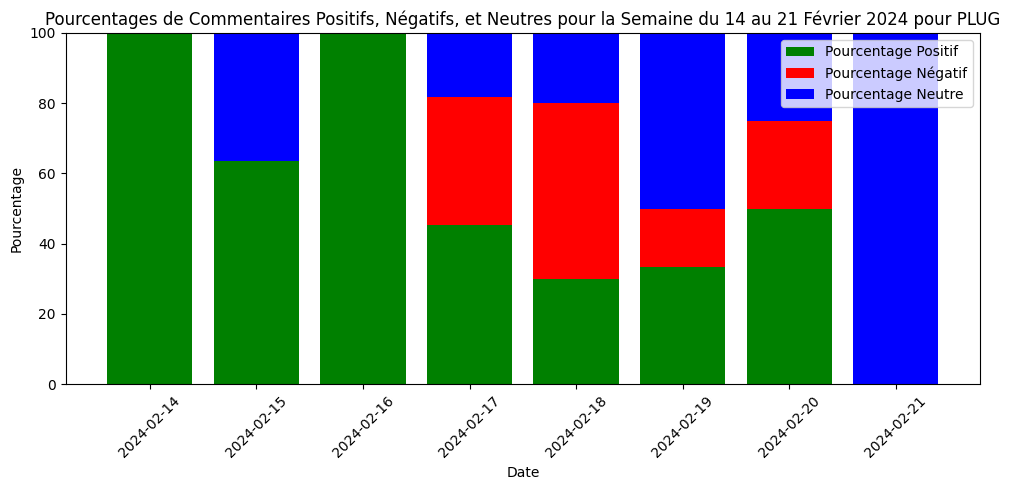

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Charger les données à partir du fichier CSV
df = pd.read_csv('.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Définir la semaine que vous souhaitez afficher
start_date = "2024-02-14"
end_date = "2024-02-21"

# Filtrer le DataFrame pour la semaine souhaitée
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
weekly_df = df.loc[mask]

# Calculer le pourcentage de commentaires neutres pour la semaine filtrée
weekly_df['Neutral_Percentage'] = 100 - (weekly_df['Positive_Percentage'] + weekly_df['Negative_Percentage'])

# Définir la taille du graphique
plt.figure(figsize=(10, 5))

# Créer le graphique en barres
plt.bar(weekly_df['Date'], weekly_df['Positive_Percentage'], label='Pourcentage Positif', color='green')
plt.bar(weekly_df['Date'], weekly_df['Negative_Percentage'], bottom=weekly_df['Positive_Percentage'], label='Pourcentage Négatif', color='red')
plt.bar(weekly_df['Date'], weekly_df['Neutral_Percentage'], bottom=weekly_df['Positive_Percentage'] + weekly_df['Negative_Percentage'], label='Pourcentage Neutre', color='blue')

# Formater l'axe des dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Ajouter des titres et des étiquettes
plt.title('Pourcentages de Commentaires Positifs, Négatifs, et Neutres pour la Semaine du 14 au 21 Février 2024 pour PLUG')
plt.xlabel('Date')
plt.ylabel('Pourcentage')
plt.legend()

# Rotater légèrement les dates pour une meilleure lisibilité
plt.xticks(rotation=45)

# Afficher le graphique
plt.tight_layout()
plt.show()
